In [1]:
protein = 'TTR'
subset = ['native', 'fibril', 'merge']
file_cutoff = 5.5
exclusion = 3

#### Functions definition

In [2]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations

native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

def prepare_pairs_list(protein, subset, file_cutoff, exclusion):
    # Create the DataFrame of the pairs list
    pairs_list = pd.read_csv(f'FF_greta_analysis_{protein}/{protein}_{subset}_pairs_list_c{file_cutoff}_e{exclusion}.txt', sep='\\s+', index_col=False)

    pairs_list.insert(1, 'ai_resnumber', '')
    pairs_list.insert(1, 'ai_resname', '')
    pairs_list.insert(4, 'aj_resnumber', '')
    pairs_list.insert(4, 'aj_resname', '')

    # Separation of the atomtype and the aminoacid number. 
    # The atomtype column will be replaced avoiding to create a column and delete this one.
    pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
    pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
    # Replacing the atomtype values with aminoacid number as int
    pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
    pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
    # Conversion from str to int
    pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
    pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
    # Replacing the aminoacid number with the aminoacid name
    pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
    pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)

    #print(pairs_list)#.to_string())
    return pairs_list


def pairs_extraction(pairs_list, contacts_histogram, sigma_histogram, pdb_resids):
    # Function to extract the informations from the pairs list
    for an in pdb_resids:
        # pdb_resids is the aminocid numbers
        # Selection of the rows contaning the aminoacid number of interest.
        # Note the | and not the &
        is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

        # Filtering a dataframe containing only the aminoacid selected.
        pairs_an = pairs_list[is_an]
        #print(pairs_an.to_string())

        print(f'\nTotal amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
        pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
        pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)
        #print(pairs_an.to_string())
        
        # Create Pandas Series with contact counts for every aminoacid in an selection:
        # an_with_who count of the unique values in column "an_with_who" in pairs_an dataframe
        an_with_who = pairs_an.an_with_who.value_counts()
        print(f'\nList of contacts based on aminoacid:\n{an_with_who.to_string()}')

        # Change "an_with_who" in a dictionary to put in a matrix
        contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
        #print(f'\nAnd the consequent nested dictionary:\n{contacts_histogram}\n')


        # Matrix Sigma creation
        set_an_with_who = set(pairs_an["an_with_who"])

        sigma_dict = {}
        for s in set_an_with_who:
            sigma_dict[s] = 0.00000
            is_s = pairs_an["an_with_who"] == s
            sigmas_an = pairs_an[is_s]
            mean_sigma = sigmas_an['sigma'].mean()
            print(f'Average sigma of {amino_dict_num.get(an)} with {s}', '%.5f'%mean_sigma)
            sigma_dict[s] = '%.5f'%mean_sigma

        sigma_histogram['{0}'.format(an)] = sigma_dict
    
    return contacts_histogram, sigma_histogram


def make_contacts_histo_df(contacts_histogram):
    # Contact dataframe preparation
    histo_df = pd.DataFrame(contacts_histogram)
    histo_df[''] = histo_df.index.astype(str)
    histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
    histo_df.sort_values(by = [''], inplace = True)
    histo_df.drop(columns='', inplace=True)
    histo_df = histo_df.fillna(0)
    histo_df.columns = list(amino_dict_num.values())
    print(histo_df.to_string())
    return histo_df

/home/emanuele/anaconda2/envs/py37/lib/python3.7/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/emanuele/anaconda2/envs/py37/lib/python3.7/site-packages/MDAnalysis/core/topologyattrs.py:2261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


#### Start

In [3]:
native_pairs = prepare_pairs_list(protein, subset[0], file_cutoff, exclusion)
fibril_pairs = prepare_pairs_list(protein, subset[1], file_cutoff, exclusion)
merge_pairs = prepare_pairs_list(protein, subset[2], file_cutoff, exclusion)

native_contacts_histogram = {}
fibril_contacts_histogram = {}
merge_contacts_histogram = {}

native_sigma_histogram = {}
fibril_sigma_histogram = {}
merge_sigma_histogram = {}

native_contacts_histogram, native_sigma_histogram = pairs_extraction(native_pairs, native_contacts_histogram, native_sigma_histogram, pdb_resids)
fibril_contacts_histogram, fibril_sigma_histogram = pairs_extraction(fibril_pairs, fibril_contacts_histogram, fibril_sigma_histogram, pdb_resids)
merge_contacts_histogram, merge_sigma_histogram = pairs_extraction(merge_pairs, merge_contacts_histogram, merge_sigma_histogram, pdb_resids)

native_contacts = make_contacts_histo_df(native_contacts_histogram)
fibril_contacts = make_contacts_histo_df(fibril_contacts_histogram)
merge_contacts = make_contacts_histo_df(merge_contacts_histogram)


Total amount of contacts made by TYR_1: 1

List of contacts based on aminoacid:
ALA_4    1
Average sigma of TYR_1 with ALA_4 0.41468

Total amount of contacts made by THR_2: 0

List of contacts based on aminoacid:
Series([], )

Total amount of contacts made by ILE_3: 1

List of contacts based on aminoacid:
LEU_6    1
Average sigma of ILE_3 with LEU_6 0.36902

Total amount of contacts made by ALA_4: 2

List of contacts based on aminoacid:
TYR_1    1
LEU_7    1
Average sigma of ALA_4 with LEU_7 0.34271
Average sigma of ALA_4 with TYR_1 0.41468

Total amount of contacts made by ALA_5: 3

List of contacts based on aminoacid:
SER_8    3
Average sigma of ALA_5 with SER_8 0.37813

Total amount of contacts made by LEU_6: 1

List of contacts based on aminoacid:
ILE_3    1
Average sigma of LEU_6 with ILE_3 0.36902

Total amount of contacts made by LEU_7: 1

List of contacts based on aminoacid:
ALA_4    1
Average sigma of LEU_7 with ALA_4 0.34271

Total amount of contacts made by SER_8: 27

List

Text(0.5, 1.07, 'Cutoff 5.5, ex 3')

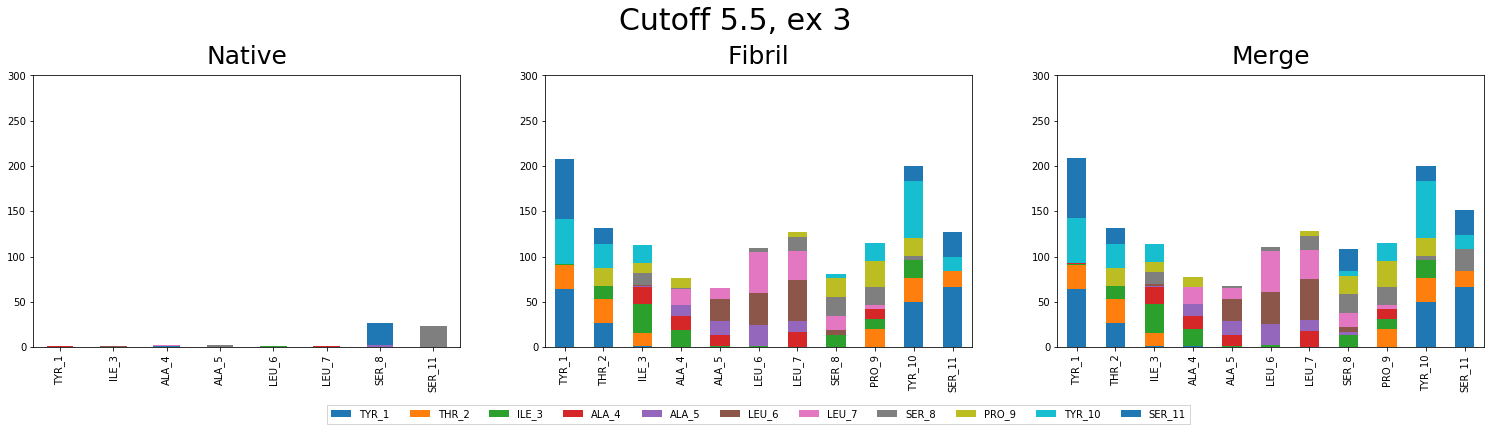

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (26,5))
ax1 = native_contacts.plot(ax=ax1, kind = "bar", stacked = True)
ax1.set_title('Native', fontsize = 25, y = 1.02)
ax1.get_legend().remove()
ax1.set_ylim(0, 300)

ax2 = fibril_contacts.plot(ax=ax2, kind = "bar", stacked = True)
ax2.set_title('Fibril', fontsize = 25, y = 1.02)
ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
ax2.set_ylim(0, 300)

ax3 = merge_contacts.plot(ax=ax3, kind = "bar", stacked = True)
ax3.set_title('Merge', fontsize = 25, y = 1.02)
ax3.get_legend().remove()
ax3.set_ylim(0, 300)

figure.suptitle(f'Cutoff {file_cutoff}, ex {exclusion}', fontsize = 30, y = 1.07)


Text(0.5, 1.07, 'Cutoff 5.5, ex 3')

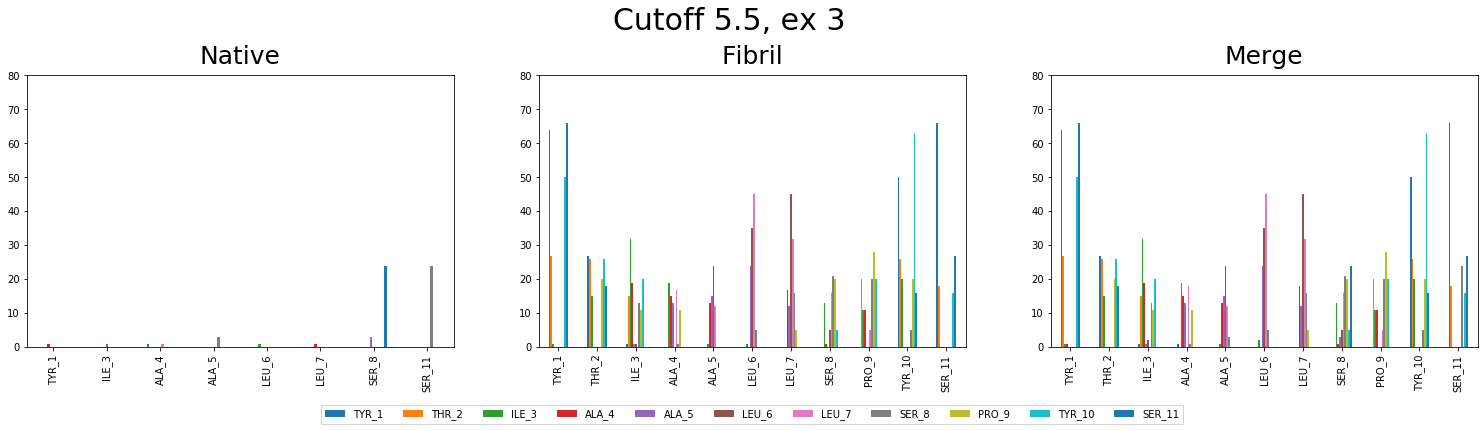

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (26,5))
ax1 = native_contacts.plot(ax=ax1, kind = "bar", stacked = False)
ax1.set_title('Native', fontsize = 25, y = 1.02)
ax1.get_legend().remove()
ax1.set_ylim(0, 80)

ax2 = fibril_contacts.plot(ax=ax2, kind = "bar", stacked = False)
ax2.set_title('Fibril', fontsize = 25, y = 1.02)
ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
ax2.set_ylim(0, 80)

ax3 = merge_contacts.plot(ax=ax3, kind = "bar", stacked = False)
ax3.set_title('Merge', fontsize = 25, y = 1.02)
ax3.get_legend().remove()
ax3.set_ylim(0, 80)

figure.suptitle(f'Cutoff {file_cutoff}, ex {exclusion}', fontsize = 30, y = 1.07)


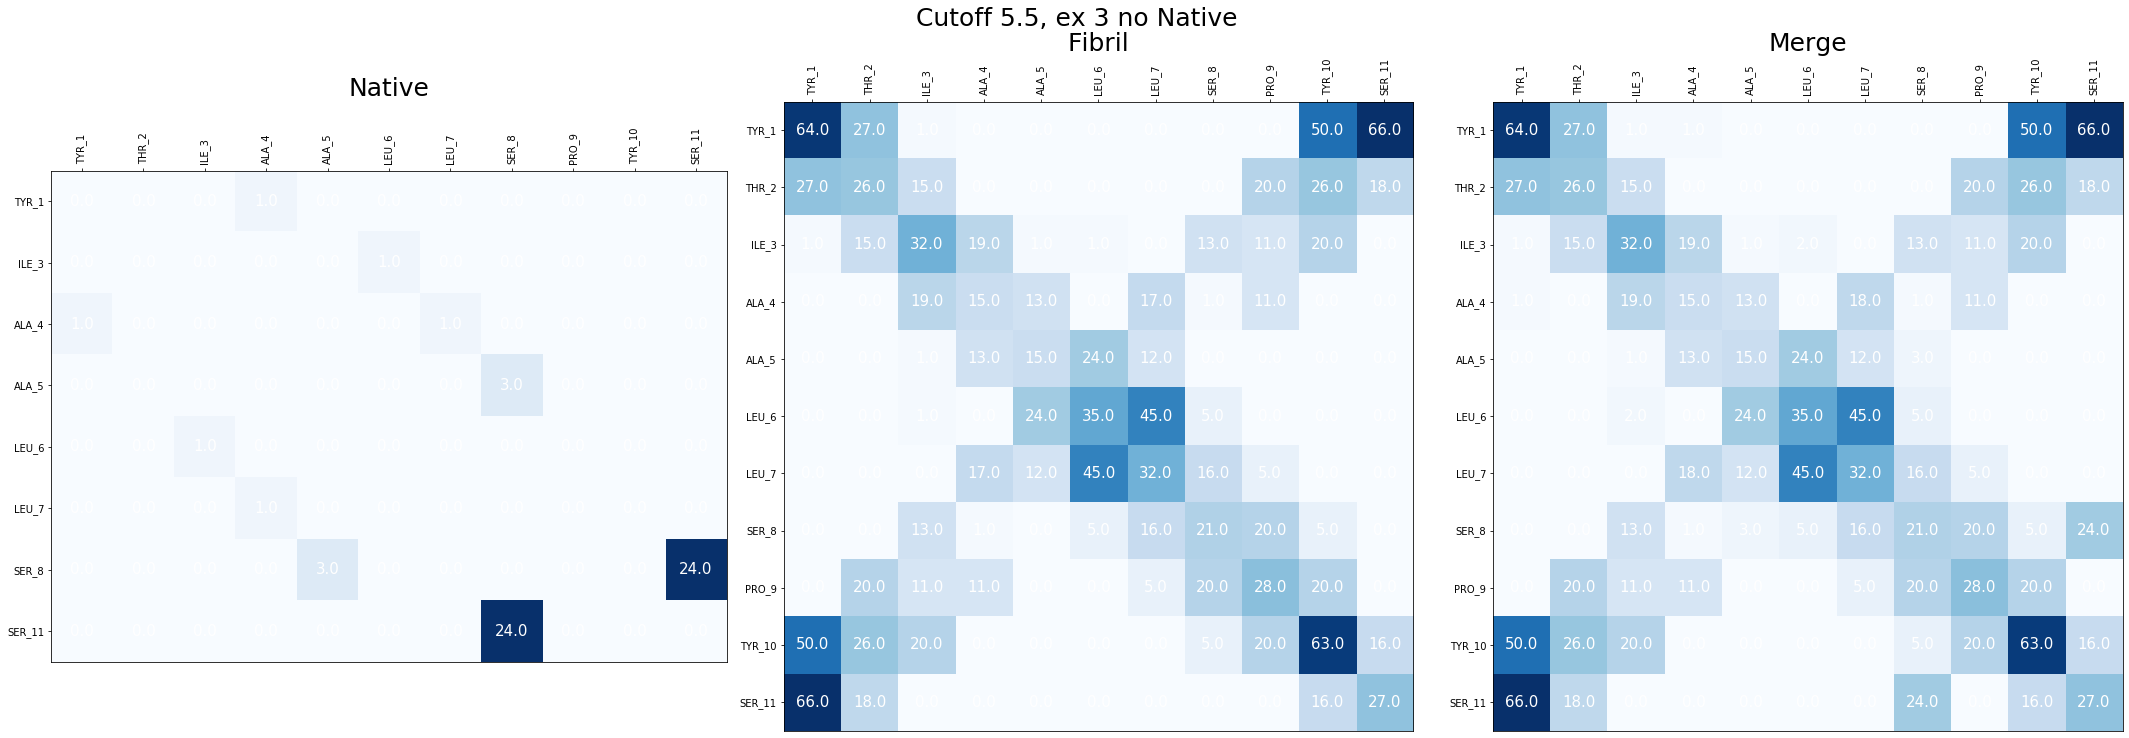

In [6]:
import numpy as np


# NATIVE
native_matrix = native_contacts.to_numpy()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30,10))
ax1.imshow(native_matrix, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax1.set_xticks(np.arange(len(native_contacts.columns)))
ax1.set_yticks(np.arange(len(native_contacts.index)))
# Naming all the axis values
ax1.set_xticklabels(list(native_contacts.columns))
ax1.set_yticklabels(list(native_contacts.index))
# Rotate x labels
ax1.xaxis.tick_top()
ax1.set_title('Native', fontsize = 25, y = 1.14)
plt.setp(ax1.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(native_contacts.index)):
    for j in range(len(native_contacts.columns)):
        text = ax1.text(j,i, native_matrix[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()


# FIBRIL
fibril_matrix = fibril_contacts.to_numpy()
ax2.imshow(fibril_matrix, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax2.set_xticks(np.arange(len(fibril_contacts.columns)))
ax2.set_yticks(np.arange(len(fibril_contacts.index)))
# Naming all the axis values
ax2.set_xticklabels(list(fibril_contacts.columns))
ax2.set_yticklabels(list(fibril_contacts.index))
# Rotate x labels
ax2.xaxis.tick_top()
ax2.set_title('Fibril', fontsize = 25, y = 1.04)
plt.setp(ax2.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(fibril_contacts.index)):
    for j in range(len(fibril_contacts.columns)):
        text = ax2.text(j,i, fibril_matrix[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()


# MERGE
merge_matrix = merge_contacts.to_numpy()
ax3.imshow(merge_matrix, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax3.set_xticks(np.arange(len(merge_contacts.columns)))
ax3.set_yticks(np.arange(len(merge_contacts.index)))
# Naming all the axis values
ax3.set_xticklabels(list(merge_contacts.columns))
ax3.set_yticklabels(list(merge_contacts.index))
# Rotate x labels
ax3.xaxis.tick_top()
ax3.set_title('Merge', fontsize = 25, y = 1.04)
plt.setp(ax3.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(merge_contacts.index)):
    for j in range(len(merge_contacts.columns)):
        text = ax3.text(j,i, merge_matrix[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.suptitle(f'Cutoff {file_cutoff}, ex {exclusion} no Native', fontsize = 25, y = 1.02)
fig.tight_layout()

In [7]:
# Making a normalized dataframe and matrix
pd.options.display.float_format = '{:.2f}'.format

native_contacts_norm = native_contacts.div(native_contacts.max().max())
print(native_contacts_norm.to_string())

fibril_contacts_norm = fibril_contacts.div(fibril_contacts.max().max())
print(fibril_contacts_norm.to_string())

merge_contacts_norm = merge_contacts.div(merge_contacts.max().max())
print(merge_contacts_norm.to_string())

        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    0.00   0.00   0.00   0.04   0.00   0.00   0.00   0.00   0.00    0.00    0.00
ILE_3    0.00   0.00   0.00   0.00   0.00   0.04   0.00   0.00   0.00    0.00    0.00
ALA_4    0.04   0.00   0.00   0.00   0.00   0.00   0.04   0.00   0.00    0.00    0.00
ALA_5    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.12   0.00    0.00    0.00
LEU_6    0.00   0.00   0.04   0.00   0.00   0.00   0.00   0.00   0.00    0.00    0.00
LEU_7    0.00   0.00   0.00   0.04   0.00   0.00   0.00   0.00   0.00    0.00    0.00
SER_8    0.00   0.00   0.00   0.00   0.12   0.00   0.00   0.00   0.00    0.00    1.00
SER_11   0.00   0.00   0.00   0.00   0.00   0.00   0.00   1.00   0.00    0.00    0.00
        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    0.97   0.41   0.02   0.00   0.00   0.00   0.00   0.00   0.00    0.76    1.00
THR_2    0.41   0.39   0.23   0.00   0.00   0.00   0.0

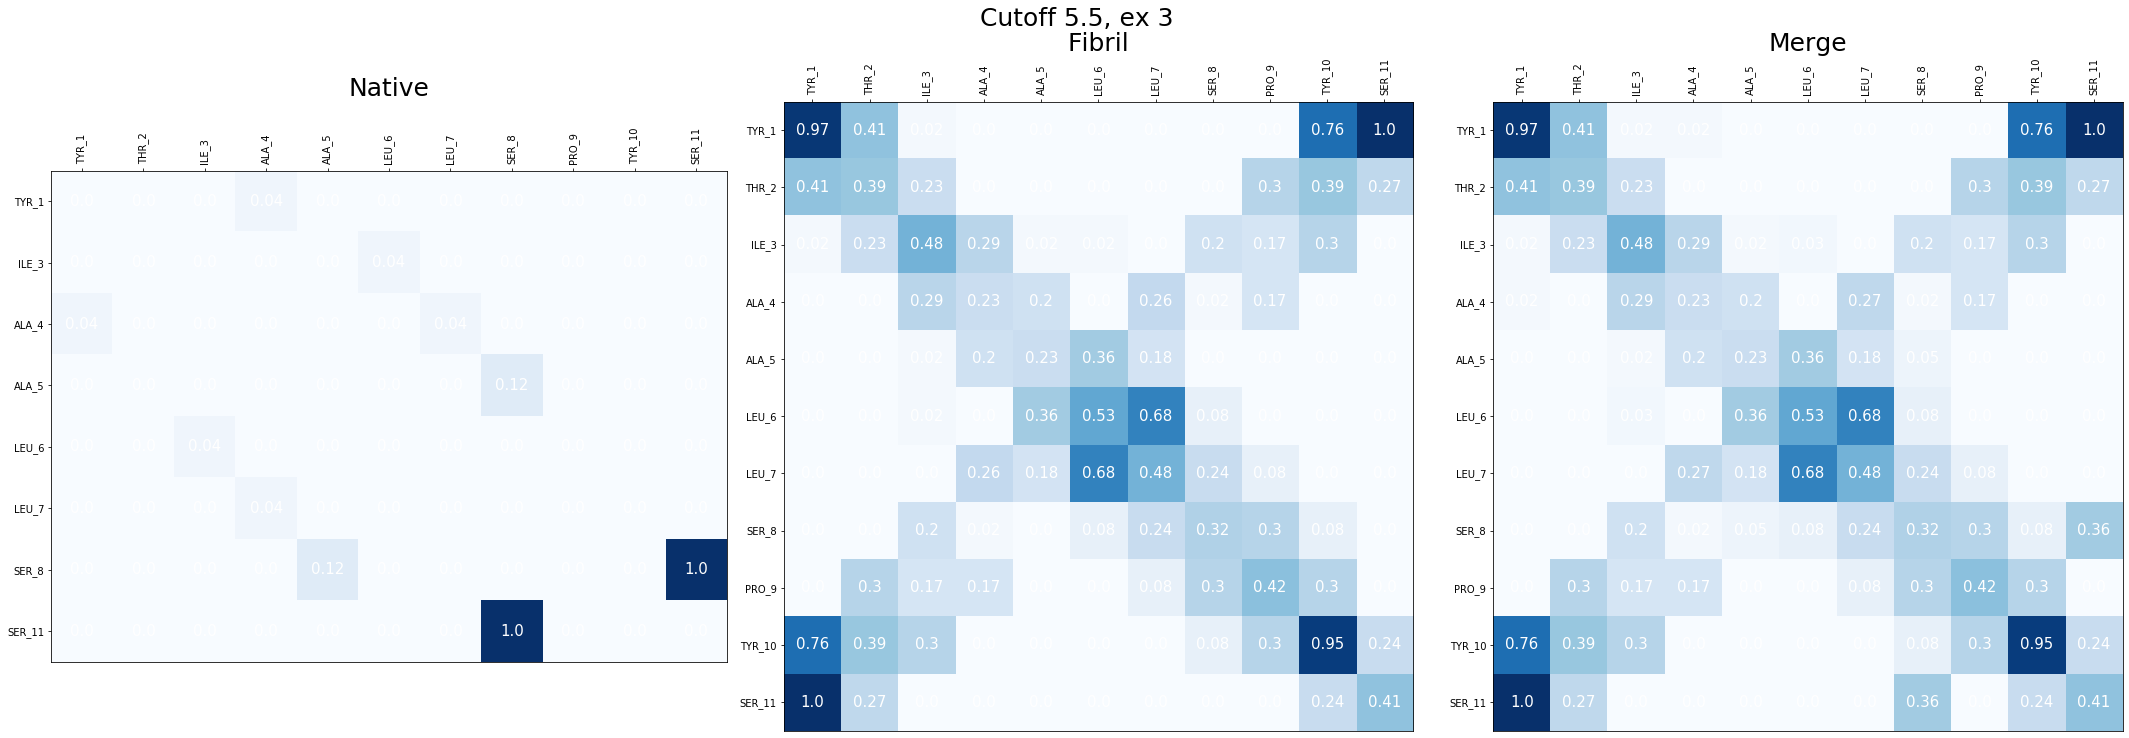

In [8]:
native_matrix_norm = native_contacts_norm.to_numpy()
native_matrix_norm = native_matrix_norm.round(decimals = 2)

fibril_matrix_norm = fibril_contacts_norm.to_numpy()
fibril_matrix_norm = fibril_matrix_norm.round(decimals = 2)

merge_matrix_norm = merge_contacts_norm.to_numpy()
merge_matrix_norm = merge_matrix_norm.round(decimals = 2)

# NATIVE
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30,10))
ax1.imshow(native_matrix_norm, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax1.set_xticks(np.arange(len(native_contacts_norm.columns)))
ax1.set_yticks(np.arange(len(native_contacts_norm.index)))
# Naming all the axis values
ax1.set_xticklabels(list(native_contacts_norm.columns))
ax1.set_yticklabels(list(native_contacts_norm.index))
# Rotate x labels
ax1.xaxis.tick_top()
ax1.set_title('Native', fontsize = 25, y = 1.14)
plt.setp(ax1.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(native_contacts_norm.index)):
    for j in range(len(native_contacts_norm.columns)):
        text = ax1.text(j,i, native_matrix_norm[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()


# FIBRIL
ax2.imshow(fibril_matrix_norm, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax2.set_xticks(np.arange(len(fibril_contacts_norm.columns)))
ax2.set_yticks(np.arange(len(fibril_contacts_norm.index)))
# Naming all the axis values
ax2.set_xticklabels(list(fibril_contacts_norm.columns))
ax2.set_yticklabels(list(fibril_contacts_norm.index))
# Rotate x labels
ax2.xaxis.tick_top()
ax2.set_title('Fibril', fontsize = 25, y = 1.04)
plt.setp(ax2.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(fibril_contacts_norm.index)):
    for j in range(len(fibril_contacts_norm.columns)):
        text = ax2.text(j,i, fibril_matrix_norm[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()


# MERGE
ax3.imshow(merge_matrix_norm, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax3.set_xticks(np.arange(len(merge_contacts_norm.columns)))
ax3.set_yticks(np.arange(len(merge_contacts_norm.index)))
# Naming all the axis values
ax3.set_xticklabels(list(merge_contacts_norm.columns))
ax3.set_yticklabels(list(merge_contacts_norm.index))
# Rotate x labels
ax3.xaxis.tick_top()
ax3.set_title('Merge', fontsize = 25, y = 1.04)
plt.setp(ax3.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(merge_contacts_norm.index)):
    for j in range(len(merge_contacts_norm.columns)):
        text = ax3.text(j,i, merge_matrix_norm[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.suptitle(f'Cutoff {file_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
fig.tight_layout()

In [9]:
# Sigmas dataframe preparation
pd.options.display.float_format = '{:,.5f}'.format
native_histo_sigma = pd.DataFrame(native_sigma_histogram)
native_histo_sigma = native_histo_sigma.apply(pd.to_numeric)
native_histo_sigma[''] = native_histo_sigma.index.astype(str)
native_histo_sigma[''] = native_histo_sigma[''].str.split('_').str[1].astype(int)
native_histo_sigma.sort_values(by = [''], inplace = True)
native_histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
native_histo_sigma.columns = list(amino_dict_num.values())
print(native_histo_sigma.to_string())

fibril_histo_sigma = pd.DataFrame(fibril_sigma_histogram)
fibril_histo_sigma = fibril_histo_sigma.apply(pd.to_numeric)
fibril_histo_sigma[''] = fibril_histo_sigma.index.astype(str)
fibril_histo_sigma[''] = fibril_histo_sigma[''].str.split('_').str[1].astype(int)
fibril_histo_sigma.sort_values(by = [''], inplace = True)
fibril_histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
fibril_histo_sigma.columns = list(amino_dict_num.values())
print(native_histo_sigma.to_string())

merge_histo_sigma = pd.DataFrame(merge_sigma_histogram)
merge_histo_sigma = merge_histo_sigma.apply(pd.to_numeric)
merge_histo_sigma[''] = merge_histo_sigma.index.astype(str)
merge_histo_sigma[''] = merge_histo_sigma[''].str.split('_').str[1].astype(int)
merge_histo_sigma.sort_values(by = [''], inplace = True)
merge_histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
native_histo_sigma.columns = list(amino_dict_num.values())
print(native_histo_sigma.to_string())


         TYR_1  THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8  PRO_9  TYR_10  SER_11
TYR_1      nan    nan     nan 0.41468     nan     nan     nan     nan    nan     nan     nan
ILE_3      nan    nan     nan     nan     nan 0.36902     nan     nan    nan     nan     nan
ALA_4  0.41468    nan     nan     nan     nan     nan 0.34271     nan    nan     nan     nan
ALA_5      nan    nan     nan     nan     nan     nan     nan 0.37813    nan     nan     nan
LEU_6      nan    nan 0.36902     nan     nan     nan     nan     nan    nan     nan     nan
LEU_7      nan    nan     nan 0.34271     nan     nan     nan     nan    nan     nan     nan
SER_8      nan    nan     nan     nan 0.37813     nan     nan     nan    nan     nan 0.39486
SER_11     nan    nan     nan     nan     nan     nan     nan 0.39486    nan     nan     nan
         TYR_1  THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8  PRO_9  TYR_10  SER_11
TYR_1      nan    nan     nan 0.41468     nan     nan     nan     nan 

0.34271
0.37235999999999997
0.37235999999999997


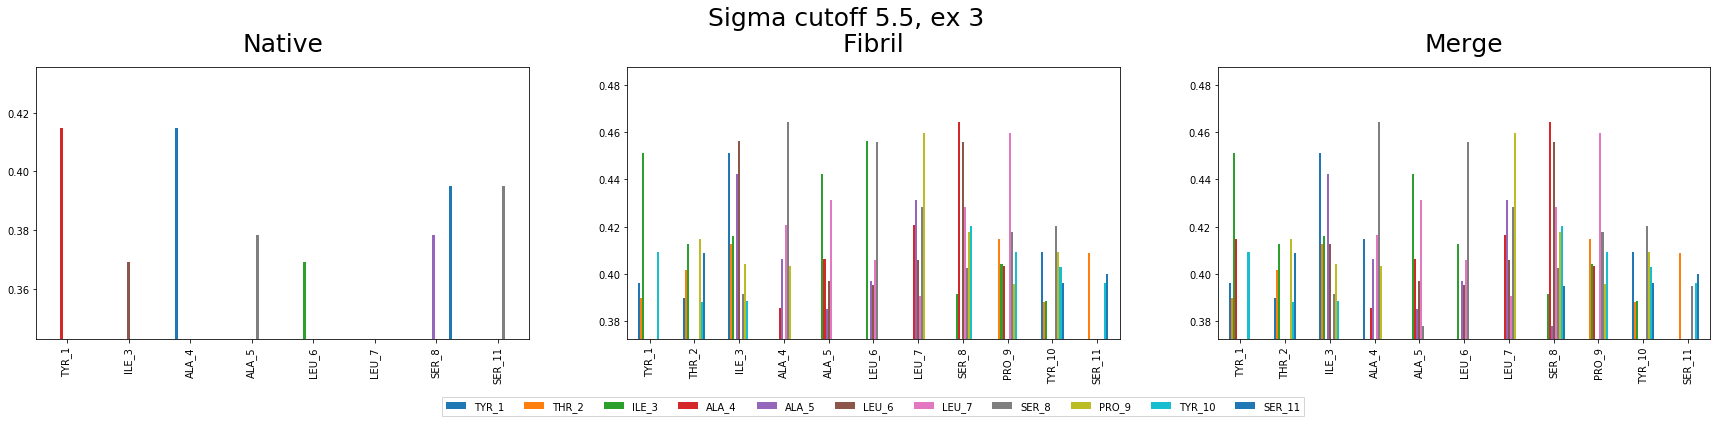

In [10]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (90,10))
ax1 = native_histo_sigma.plot(ax = ax1, kind = "bar", stacked = False, figsize = (30,5))
ax1.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax1.set_ylim(bottom=(native_histo_sigma.min()).min())
ax1.set_title('Native', fontsize = 25, y = 1.04)
ax1.get_legend().remove()
print((native_histo_sigma.min()).min())

ax2 = fibril_histo_sigma.plot(ax = ax2, kind = "bar", stacked = False, figsize = (30,5))
ax2.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax2.set_ylim(bottom=(fibril_histo_sigma.min()).min())
ax2.set_title('Fibril', fontsize = 25, y = 1.04)
ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
print((fibril_histo_sigma.min()).min())

ax3 = merge_histo_sigma.plot(ax=ax3, kind = "bar", stacked = False, figsize = (30,5))
ax3.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax3.set_ylim(bottom=(fibril_histo_sigma.min()).min())
ax3.set_title('Merge', fontsize = 25, y = 1.04)
fig.suptitle(f'Sigma cutoff {file_cutoff}, ex {exclusion}', fontsize = 25, y = 1.05)
ax3.get_legend().remove()
print((merge_histo_sigma.min()).min())

In [11]:
# Distance dataframe preparation

native_histo_distance = native_histo_sigma.apply(lambda a: a*(2**(1/6)))
native_histo_distance[''] = native_histo_distance.index.astype(str)
native_histo_distance[''] = native_histo_distance[''].str.split('_').str[1].astype(int)
native_histo_distance.sort_values(by = [''], inplace = True)
native_histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
native_histo_distance.columns = list(amino_dict_num.values())
print(native_histo_distance.to_string())

fibril_histo_distance = fibril_histo_sigma.apply(lambda a: a*(2**(1/6)))
fibril_histo_distance[''] = fibril_histo_distance.index.astype(str)
fibril_histo_distance[''] = fibril_histo_distance[''].str.split('_').str[1].astype(int)
fibril_histo_distance.sort_values(by = [''], inplace = True)
fibril_histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
fibril_histo_distance.columns = list(amino_dict_num.values())
print(fibril_histo_distance.to_string())

merge_histo_distance = merge_histo_sigma.apply(lambda a: a*(2**(1/6)))
merge_histo_distance[''] = merge_histo_distance.index.astype(str)
merge_histo_distance[''] = merge_histo_distance[''].str.split('_').str[1].astype(int)
merge_histo_distance.sort_values(by = [''], inplace = True)
merge_histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
merge_histo_distance.columns = list(amino_dict_num.values())
print(merge_histo_distance.to_string())

         TYR_1  THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8  PRO_9  TYR_10  SER_11
TYR_1      nan    nan     nan 0.46546     nan     nan     nan     nan    nan     nan     nan
ILE_3      nan    nan     nan     nan     nan 0.41421     nan     nan    nan     nan     nan
ALA_4  0.46546    nan     nan     nan     nan     nan 0.38468     nan    nan     nan     nan
ALA_5      nan    nan     nan     nan     nan     nan     nan 0.42444    nan     nan     nan
LEU_6      nan    nan 0.41421     nan     nan     nan     nan     nan    nan     nan     nan
LEU_7      nan    nan     nan 0.38468     nan     nan     nan     nan    nan     nan     nan
SER_8      nan    nan     nan     nan 0.42444     nan     nan     nan    nan     nan 0.44322
SER_11     nan    nan     nan     nan     nan     nan     nan 0.44322    nan     nan     nan
         TYR_1   THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8   PRO_9  TYR_10  SER_11
TYR_1  0.44472 0.43760 0.50643     nan     nan     nan     nan     n

0.38467896857610523
0.4179599683084781
0.4179599683084781


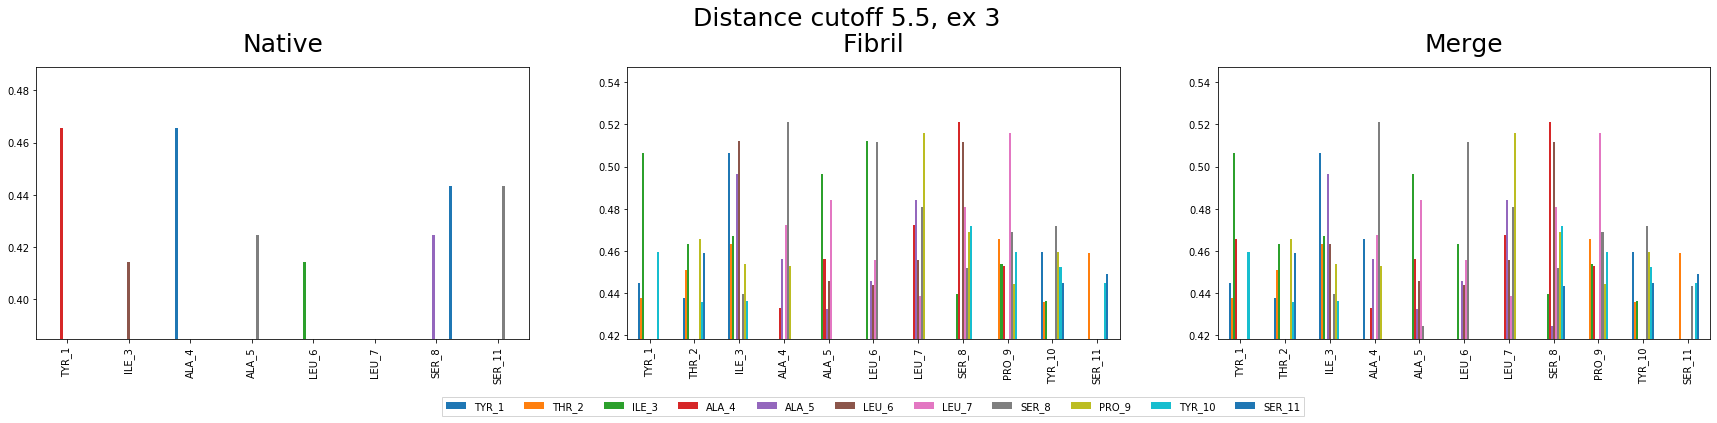

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (90,10))
ax1 = native_histo_distance.plot(ax = ax1, kind = "bar", stacked = False, figsize = (30,5))
ax1.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax1.set_ylim(bottom=(native_histo_distance.min()).min())
ax1.set_title('Native', fontsize = 25, y = 1.04)
ax1.get_legend().remove()
print((native_histo_distance.min()).min())

ax2 = fibril_histo_distance.plot(ax = ax2, kind = "bar", stacked = False, figsize = (30,5))
ax2.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax2.set_ylim(bottom=(fibril_histo_distance.min()).min())
ax2.set_title('Fibril', fontsize = 25, y = 1.04)
ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
print((fibril_histo_distance.min()).min())

ax3 = merge_histo_distance.plot(ax=ax3, kind = "bar", stacked = False, figsize = (30,5))
ax3.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax3.set_ylim(bottom=(fibril_histo_distance.min()).min())
ax3.set_title('Merge', fontsize = 25, y = 1.04)
fig.suptitle(f'Distance cutoff {file_cutoff}, ex {exclusion}', fontsize = 25, y = 1.05)
ax3.get_legend().remove()
print((merge_histo_distance.min()).min())